# Final project 

### Part 1 create databases and load data

Setup SQL environment.

In [1]:
%load_ext sql
!pip freeze | grep -E 'ipython-sql|psycopg2'

ipython-sql==0.3.9
psycopg2==2.7.5
psycopg2-binary==2.7.5


In [5]:
!createdb -U student final_10

perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = (unset),
	LC_CTYPE = "UTF-8",
	LANG = "en_US.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to a fallback locale ("en_US.UTF-8").


In [2]:
%sql postgresql://student@/final_10

'Connected: student@final_10'

Create SQL tables for the data.

In [32]:
%%sql
DROP TABLE IF EXISTS users;

CREATE TABLE users (
  USER_ID   varchar(10) Not NULL, 
  GENDER   varchar(1),
  AGE varchar(7),
  OCCUPATION  varchar(3),
  CITY_CAT  varchar(1), 
  STAY_YEARS  varchar(2) ,
  MARITAL varchar(1),
  PURCHASE_AMT numeric(14,2),
  PRIMARY KEY (USER_ID)
)

 * postgresql://student@/final_10
Done.
Done.


[]

In [33]:
%%sql
select * from users;

 * postgresql://student@/final_10
0 rows affected.


user_id,gender,age,occupation,city_cat,stay_years,marital,purchase_amt


In [76]:
%%sql
DROP TABLE IF EXISTS products;

CREATE TABLE products (
  PRODUCT_ID varchar(10) Not NULL, 
  CAT1 numeric(14,0) Not NULL,
  CAT2 numeric(14,0),
  CAT3 numeric(14,0),
  PRODUCT_SALE_AMT numeric(14,2),
  NO_OF_ORDER numeric(14,2),
  PRIMARY KEY (PRODUCT_ID)
)

 * postgresql://student@/final_10
Done.
Done.


[]

In [35]:
%%sql
DROP TABLE IF EXISTS facts;

CREATE TABLE facts (
  USER_ID varchar(10) Not NULL, 
  PRODUCT_ID varchar(10) Not NULL,
  TRANSACTION_AMT numeric(14,2)
)

 * postgresql://student@/final_10
Done.
Done.


[]

Load data into tables.

In [77]:
%%sql
COPY products
FROM '/home/ubuntu/demension_product.csv' DELIMITER ',' CSV HEADER

 * postgresql://student@/final_10
3631 rows affected.


[]

In [37]:
%%sql
COPY users
FROM '/home/ubuntu/demension_user.csv' DELIMITER ',' CSV HEADER

 * postgresql://student@/final_10
5891 rows affected.


[]

In [39]:
%%sql
COPY facts
FROM '/home/ubuntu/order_facts.csv' DELIMITER ',' CSV HEADER

 * postgresql://student@/final_10
550068 rows affected.


[]

Take a glance about what these databases look like.

In [41]:
%%sql
select * from products limit 3;

 * postgresql://student@/final_10
3 rows affected.


product_id,cat1,cat2,cat3,product_sale_amt
P00109242,6,8,10,7060551.00
P00040442,5,14,,696717.00
P00233342,1,15,16,4727286.00


In [42]:
%%sql
select * from users limit 3;

 * postgresql://student@/final_10
3 rows affected.


user_id,gender,age,occupation,city_cat,stay_years,marital,purchase_amt
1000002,M,55+,16,C,4+,0,810472.00
1000136,M,18-25,2,B,3,0,1562462.00
1000705,M,26-35,4,C,0,1,684297.00


In [43]:
%%sql
select * from facts limit 3;

 * postgresql://student@/final_10
3 rows affected.


user_id,product_id,transaction_amt
1000001,P00069042,8370.00
1000001,P00248942,15200.00
1000001,P00087842,1422.00


### Part 2 basic analysis

Visualize data  - **this part can be move to the last of this notebook later.** It's handy to visualize data here so as to get some insights before we do the analysis.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import numpy as np
import seaborn as sns

In [4]:
engine = create_engine('postgresql://student@/final_10')

In [5]:
users = pd.read_sql_table('users',con=engine)

In [6]:
users.head()

,user_id,gender,age,occupation,city_cat,stay_years,marital,purchase_amt
0,1000002,M,55+,16,C,4+,0,810472.0
1,1000136,M,18-25,2,B,3,0,1562462.0
2,1000705,M,26-35,4,C,0,1,684297.0
3,1000760,M,55+,15,A,4+,1,300758.0
4,1001593,M,26-35,16,C,1,1,779007.0


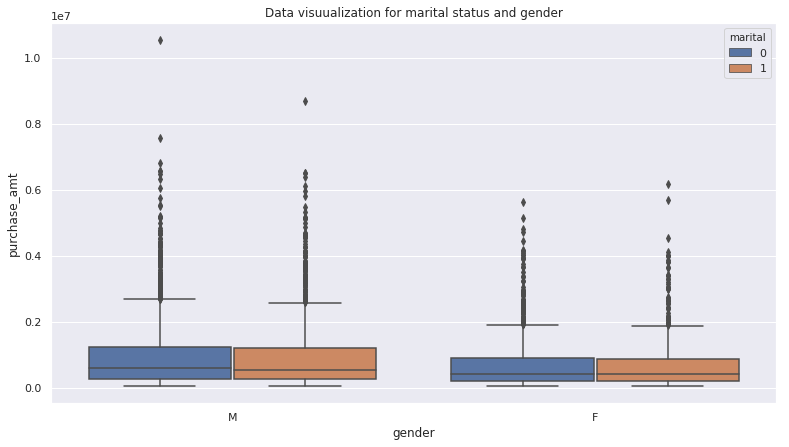

In [7]:
sns.set()
plt.figure(figsize = (13,7))
sns.boxplot(y = 'purchase_amt',x = 'gender',hue = 'marital',data = users)
plt.title('Marital Status and Gender Distribution')
plt.show()

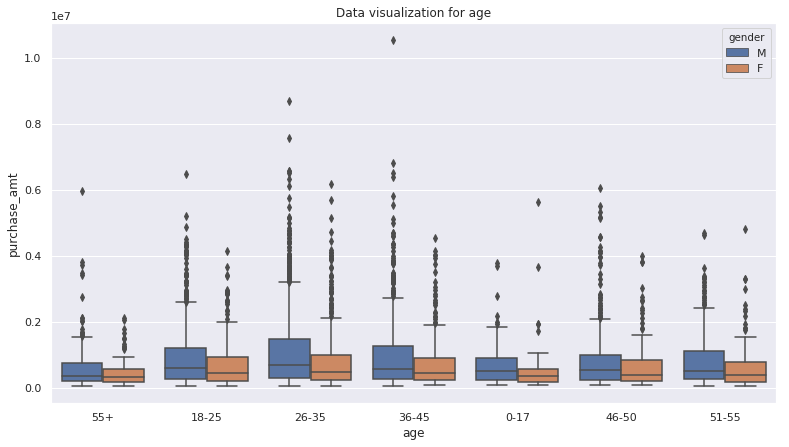

In [8]:
plt.figure(figsize = (13,7))
sns.boxplot(y = 'purchase_amt',x = 'age',hue = 'gender',data = users)
plt.title('Age and Gender Distribution')
plt.show()

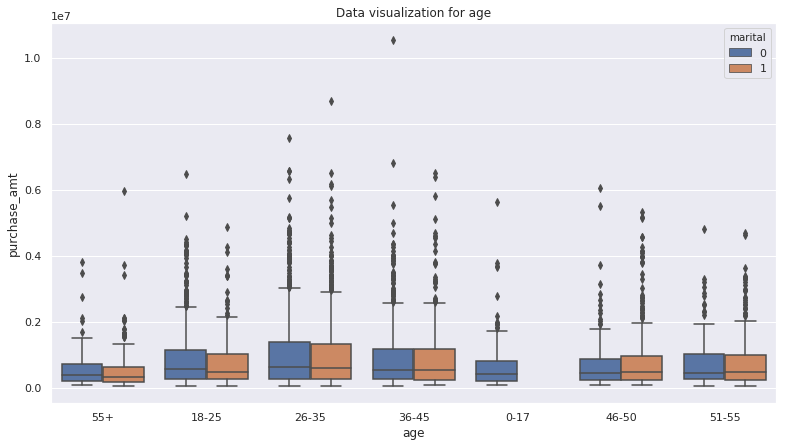

In [92]:
plt.figure(figsize = (13,7))
sns.boxplot(y = 'purchase_amt',x = 'age',hue = 'marital',data = users)
plt.title('Age and Marital Distribution')
plt.show()

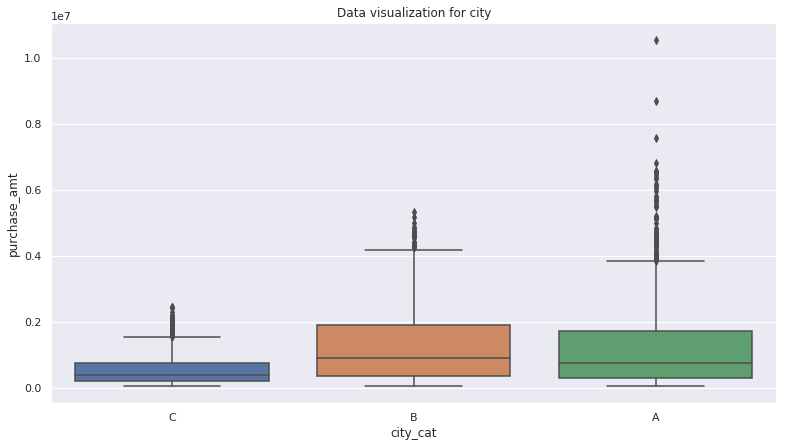

In [85]:
sns.set()
plt.figure(figsize = (13,7))
sns.boxplot(y = 'purchase_amt',x = 'city_cat',data = users)
plt.title('Buyers Location Distribution')
plt.show()

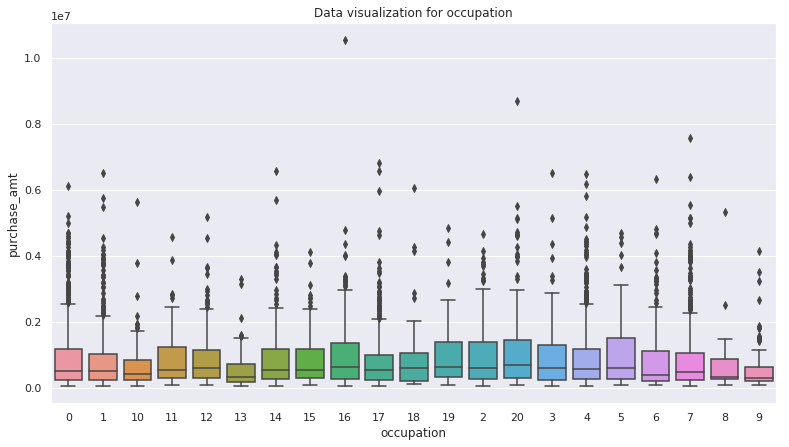

In [90]:
plt.figure(figsize = (13,7))
sns.boxplot(y = 'purchase_amt',x = 'occupation',data = users)
plt.title('Occupation Distribution')
plt.show()

### Q1 Which kind of customer should be considered a target customer? What does his or her profile look like?

#### Let's decomposite this question. Is purchase amt impacted by gender?

get the distribution of gender, and average purchase amount for each gender.

Male:

In [54]:
%%sql
select M.count_M,M.ttl_purchase_amt, M.ttl_purchase_amt/M.count_M as avg_m_purchase_amt from
(select count(gender) as count_M,sum(purchase_amt) as ttl_purchase_amt from users
where gender = 'M') as M;

 * postgresql://student@/final_10
1 rows affected.


count_m,ttl_purchase_amt,avg_m_purchase_amt
4225,3909580100.00,925344.402366863905


Female:

In [27]:
%%sql
select F.count_F,round(F.ttl_purchase_amt,2) as F_ttl_purchase_amt, round(F.ttl_purchase_amt/F.count_F,2) as avg_f_purchase_amt from
(select count(gender) as count_F ,sum(purchase_amt) as ttl_purchase_amt from users
where gender = 'F') as F;

 * postgresql://student@/final_10
1 rows affected.


count_f,f_ttl_purchase_amt,avg_f_purchase_amt
1666,1186232642.00,712024.39


#### Is purchase amt impacted by marriage?

male, not married:

In [28]:
%%sql
select M0.count_M0,round(M0.ttl_purchase_amt,2) as M0_ttl_purchase_amt, round(M0.ttl_purchase_amt/M0.count_M0,2) as avg_m0_purchase_amt from
(select count(gender) as count_M0,sum(purchase_amt) as ttl_purchase_amt from users
where gender = 'M' and marital = '0') as M0;

 * postgresql://student@/final_10
1 rows affected.


count_m0,m0_ttl_purchase_amt,avg_m0_purchase_amt
2470,2324773320.00,941203.77


male, married:

In [30]:
%%sql
select M1.count_M1,round(M1.ttl_purchase_amt,2) as M1_ttl_purchase_amt, round(M1.ttl_purchase_amt/M1.count_M1,2) as avg_m1_purchase_amt from
(select count(gender) as count_M1,sum(purchase_amt) as ttl_purchase_amt from users
where gender = 'M' and marital = '1') as M1;

 * postgresql://student@/final_10
1 rows affected.


count_m1,m1_ttl_purchase_amt,avg_m1_purchase_amt
1755,1584806780.00,903023.81


female, not married:

In [39]:
%%sql
select F0.count_F0,round(F0.ttl_purchase_amt,2) as F0_ttl_purchase_amt, round(F0.ttl_purchase_amt/F0.count_F0,2) as avg_f0_purchase_amt from
a
where gender = 'F' and marital = '0') as F0;

 * postgresql://student@/final_10
1 rows affected.


count_f0,f0_ttl_purchase_amt,avg_f0_purchase_amt
947,684154127.00,722443.64


female, married:

In [40]:
%%sql
select F1.count_F1,round(F1.ttl_purchase_amt,2) as F1_ttl_purchase_amt, round(F1.ttl_purchase_amt/F1.count_F1,2) as avg_f1_purchase_amt from
(select count(gender) as count_F1,sum(purchase_amt) as ttl_purchase_amt from users
where gender = 'F' and marital = '1') as F1;

 * postgresql://student@/final_10
1 rows affected.


count_f1,f1_ttl_purchase_amt,avg_f1_purchase_amt
719,502078515.00,698301.13


target: men who is single.

#### Is purchase amt of customers impacted by the city they live in?

answer this question by looking at the average purchase amount of each city:

In [22]:
%%sql
select city_cat,round(avg(purchase_amt),2) as avg_purchase_amt from users group by city_cat;

 * postgresql://student@/final_10
3 rows affected.


city_cat,avg_purchase_amt
C,530043.80
B,1239328.42
A,1259781.49


target: People who live in type b and c city

#### Is purchase amt impacted by age of customers?

In [21]:
%%sql
select age,round(avg(purchase_amt),2) as avg_purchase_amt from users group by age order by avg_purchase_amt;

 * postgresql://student@/final_10
7 rows affected.


age,avg_purchase_amt
55+,539697.24
0-17,618867.81
51-55,763200.92
46-50,792548.78
18-25,854863.12
36-45,879665.71
26-35,989659.32


Target: Customers who are 18 - 45 years old 

In [37]:
%%sql
select occupation,round(avg(purchase_amt),2) as avg_purchase_amt from users group by occupation order by avg_purchase_amt;

 * postgresql://student@/final_10
21 rows affected.


occupation,avg_purchase_amt
13,513710.58
10,603356.59
9,617500.52
17,800980.56
12,812365.55
1,821303.95
6,826389.40
7,833141.39
11,833997.02
15,849715.79


Target: people who have an occupation code of 16,5,19,20

#### Maybe average is not considered a good measurement of central tendency because it takes all datapoints into account. What if we define a function to compute the median and compare the results again?

In [9]:
%%sql
CREATE OR REPLACE FUNCTION _final_median(NUMERIC[])
   RETURNS NUMERIC AS
$$
   SELECT AVG(val)
   FROM (
     SELECT val
     FROM unnest($1) val
     ORDER BY 1
     LIMIT  2 - MOD(array_upper($1, 1), 2)
     OFFSET CEIL(array_upper($1, 1) / 2.0) - 1
   ) sub;
$$
LANGUAGE 'sql' IMMUTABLE;
 
CREATE AGGREGATE median(NUMERIC) (
  SFUNC=array_append,
  STYPE=NUMERIC[],
  FINALFUNC=_final_median,
  INITCOND='{}'
);

 * postgresql://student@/final_10
Done.
(psycopg2.ProgrammingError) function "median" already exists with same argument types
 [SQL: "CREATE AGGREGATE median(NUMERIC) (\n  SFUNC=array_append,\n  STYPE=NUMERIC[],\n  FINALFUNC=_final_median,\n  INITCOND='{}'\n);"] (Background on this error at: http://sqlalche.me/e/f405)


#### Analysis the gender and marital stuff again with median

male, not married:

In [33]:
%%sql
select round(median(purchase_amt),2) as M_median from users where gender ='M' and marital = '0'

 * postgresql://student@/final_10
1 rows affected.


m_median
605553.00


male, married:

In [34]:
%%sql
select round(median(purchase_amt),2) as M_median from users where gender ='M' and marital = '1'

 * postgresql://student@/final_10
1 rows affected.


m_median
538735.00


female, not married:

In [35]:
%%sql
select round(median(purchase_amt),2) as F_median from users where gender ='F' and marital = '0'

 * postgresql://student@/final_10
1 rows affected.


f_median
406029.00


female, married:

In [36]:
%%sql
select round(median(purchase_amt),2) as F_median from users where gender ='F' and marital = '1'

 * postgresql://student@/final_10
1 rows affected.


f_median
408499.00


这里median的排名和average的排名一样呀 大家再看看 我看是一样的 可以再次印证male not married是最高 第二是male married.

Men who get married spend less,which is contradict to what we thought, while the marital status shows little impact on the purchase behavior of women.
This result seems more reliable because of the nature of the median.

**Target remains the same:** men who is single

**Plausible reason for it according to our research:**

Relationships don’t alter the basic price of services, but it does give couples one competitive advantage: their expenses are cut in half. Two people can split the bill on housing, utilities, **groceries** and social events.
**“During the holidays, I’ll buy one gift for each member of a family,” says Jean Marie Baiardi, a small business owner and actress in Los Angeles, who is single. “But they’ll give me just one gift. It feels a little uneven. There’s a lot of money attached to general societal expectations.”**
Wedding season can be a whole other financial burden for singles with the bills for wedding presents, trips to destination ceremonies and fancy attire. Singles who never marry are not repaid with gifts at their own wedding.
“If you’re a single person, you’re buying things for two people who likely have two salaries on only one salary,” DePaulo says. “But it’s not reciprocal. If you’re a single person and had an important life event and wanted to celebrate, people are unlikely to take it seriously.”

分隔符分隔符是哇大是哇大欧拉拉拉拉拉拉拉拉拉啊啦啦分隔符分隔符是哇大是哇大欧拉拉拉拉拉拉拉拉拉啊啦啦分隔符分隔符是哇大是哇大欧拉拉拉拉拉拉拉

Though married couples usually can reduce their basic living costs by sharing costs like housing, utilities, groceries, and socialing, two people already have higher cost comparing to living singlely. The overall effect of costs sharing is not strong enough to boost the purchasing power of couples.<br><br>
Besides, married couples usually have more financial concerns and plans about saving, 401K, insurance, children, housing, and more. It might be safe to assume that married couples have higher purchasing power on some specific categories of products, but in general, single person are more likely to purchase more given their slight concerns and plans about personal finance.<br><br>
Therefore, it is not surprise that single person have higher purchasing power. Several studies can be used to support this finding. For example, the 'Household spending by single persons and married couples in their twenties: a comparison' by William Hawk states that single person's percentage spending to income is greater than that of married person.<br><br> 

Hawk, W.(2011). 'Household Spending by Single Persons and Married Couples in their Twenties: a Comparison'. Consumer Expenditure Survey Anthology, 2011. https://www.bls.gov/cex/anthology11/csxanth6.pdf.


### Analysis the city stuff

In [42]:
%%sql
select city_cat,round(median(purchase_amt),2) as median_purchase_amt from users group by city_cat;

 * postgresql://student@/final_10
3 rows affected.


city_cat,median_purchase_amt
C,383206.00
B,894439.00
A,744021.00


**Target remains the same:** people who live in type a and b city

Another interesting thing here is that the median purchase amount of customer who live in type b city is much more than that of customer who live in type c city, while the average purchase amount of them looks similar. The reason is the mean of purchase amount of customers who live in type a city is sensitive to these extreme values.

Median再考虑一下？

#### Analysis of the age stuff

In [43]:
%%sql
select age,round(median(purchase_amt),2) as median_purchase_amt from users group by age order by median_purchase_amt;

 * postgresql://student@/final_10
7 rows affected.


age,median_purchase_amt
55+,332731.50
0-17,404567.00
51-55,457415.00
46-50,466398.00
36-45,525902.00
18-25,537636.00
26-35,614063.00


Target remains the same: Customers who are 18 - 45 years old 

In [44]:
%%sql
select occupation,round(median(purchase_amt),2) as median_purchase_amt from users group by occupation order by median_purchase_amt;

 * postgresql://student@/final_10
21 rows affected.


occupation,median_purchase_amt
9,302200.50
8,320894.00
13,324726.00
6,370271.50
10,425310.50
7,458181.00
1,495207.00
0,515204.50
14,517205.00
17,528665.00


Target: people who has an occupation code of 16,5,19,20 and 12.

profile of the target customer: man who is single, lives in type b or type a city, who is 18-45 year old, and has an occupation code of 16,5,19,20 or 12. 

### Q2 Which kind of products should be considered popular products?

find the most popular products

In [83]:
%%sql
select * from products limit 3

 * postgresql://student@/final_10
3 rows affected.


product_id,cat1,cat2,cat3,product_sale_amt,no_of_order
P00109242,1,1,1,7060551.00,458.00
P00040442,1,1,0,696717.00,115.00
P00233342,1,1,1,4727286.00,351.00


Sales amount will be inflated by price, therefore, it is necessary to determine popularity by no. of order as well as total sale. Plus, we are more interested in finding out some common characteristics of popular products.

#### most or least popular: by no. of order

In [79]:
%%sql
select product_id,cat1,cat2,cat3,product_sale_amt,no_of_order,cat1+cat2+cat3 as num_of_cat
from products order by no_of_order desc limit 10

 * postgresql://student@/final_10
10 rows affected.


product_id,cat1,cat2,cat3,product_sale_amt,no_of_order,num_of_cat
P00265242,1,1,0,14165515.00,1880.00,2
P00025442,1,1,1,27995166.00,1615.00,3
P00110742,1,1,1,26722309.00,1612.00,3
P00112142,1,1,1,24216006.00,1562.00,3
P00057642,1,1,1,23102780.00,1470.00,3
P00184942,1,1,1,24334887.00,1440.00,3
P00046742,1,1,1,21152882.00,1438.00,3
P00058042,1,1,0,12250634.00,1422.00,2
P00145042,1,1,1,20411342.00,1406.00,3
P00059442,1,1,1,24338343.00,1406.00,3


In [80]:
%%sql
select product_id,cat1,cat2,cat3,product_sale_amt,no_of_order,cat1+cat2+cat3 as num_of_cat
from products order by no_of_order limit 10

 * postgresql://student@/final_10
10 rows affected.


product_id,cat1,cat2,cat3,product_sale_amt,no_of_order,num_of_cat
P00156642,1,0,0,8205.00,1.00,1
P00075042,1,0,0,18456.00,1.00,1
P00238842,1,0,0,5142.00,1.00,1
P00340742,1,0,0,7989.00,1.00,1
P00224642,1,1,0,7820.00,1.00,2
P00133042,1,1,0,7053.00,1.00,2
P00012342,1,0,0,2118.00,1.00,1
P00062442,1,0,0,5436.00,1.00,1
P00104342,1,1,0,6493.00,1.00,2
P00335642,1,0,0,6883.00,1.00,1


#### most popular: by sales amt

In [81]:
%%sql
select product_id,cat1,cat2,cat3,product_sale_amt,no_of_order,cat1+cat2+cat3 as num_of_cat
from products order by product_sale_amt desc limit 10

 * postgresql://student@/final_10
10 rows affected.


product_id,cat1,cat2,cat3,product_sale_amt,no_of_order,num_of_cat
P00025442,1,1,1,27995166.00,1615.00,3
P00110742,1,1,1,26722309.00,1612.00,3
P00255842,1,0,0,25168963.00,1383.00,1
P00059442,1,1,1,24338343.00,1406.00,3
P00184942,1,1,1,24334887.00,1440.00,3
P00112142,1,1,1,24216006.00,1562.00,3
P00110942,1,1,0,23639564.00,1360.00,2
P00237542,1,1,1,23425576.00,1394.00,3
P00057642,1,1,1,23102780.00,1470.00,3
P00010742,1,1,1,22164153.00,1350.00,3


In [82]:
%%sql
select product_id,cat1,cat2,cat3,product_sale_amt,no_of_order,cat1+cat2+cat3 as num_of_cat
from products order by product_sale_amt limit 10

 * postgresql://student@/final_10
10 rows affected.


product_id,cat1,cat2,cat3,product_sale_amt,no_of_order,num_of_cat
P00091742,1,0,0,405.00,1.00,1
P00309042,1,0,0,726.00,1.00,1
P00353042,1,0,0,1545.00,1.00,1
P00325342,1,0,0,1656.00,1.00,1
P00012942,1,1,0,1717.00,1.00,2
P00287042,1,0,0,1739.00,1.00,1
P00104042,1,1,0,1745.00,1.00,2
P00357542,1,1,0,1791.00,1.00,2
P00063442,1,0,0,1866.00,1.00,1
P00293442,1,0,0,1914.00,4.00,1


Conclusion:  Product that belongs to mutipule categories tends to be more popular.

In [91]:
%%sql
drop table if exists q2_plot_amt;
create table q2_plot_amt as
select product_id,cat1,cat2,cat3,product_sale_amt,no_of_order,cat1+cat2+cat3 as num_of_cat
from products order by product_sale_amt desc

 * postgresql://student@/final_10
Done.
3631 rows affected.


[]

In [118]:
%%sql
drop table if exists q2_plot_order;
create table q2_plot_order as
select product_id,cat1,cat2,cat3,product_sale_amt,no_of_order,cat1+cat2+cat3 as num_of_cat
from products order by no_of_order desc

 * postgresql://student@/final_10
Done.
3631 rows affected.


[]

In [119]:
q2_plot_amt = pd.read_sql_table('q2_plot_amt',con=engine)
q2_plot_order = pd.read_sql_table('q2_plot_order',con=engine)

In [120]:
top100_amt = q2_plot_amt.iloc[:100,:][['product_sale_amt','num_of_cat']].groupby(by='num_of_cat').count()
top100_order = q2_plot_order.iloc[:100,:][['no_of_order','num_of_cat']].groupby(by='num_of_cat').count()

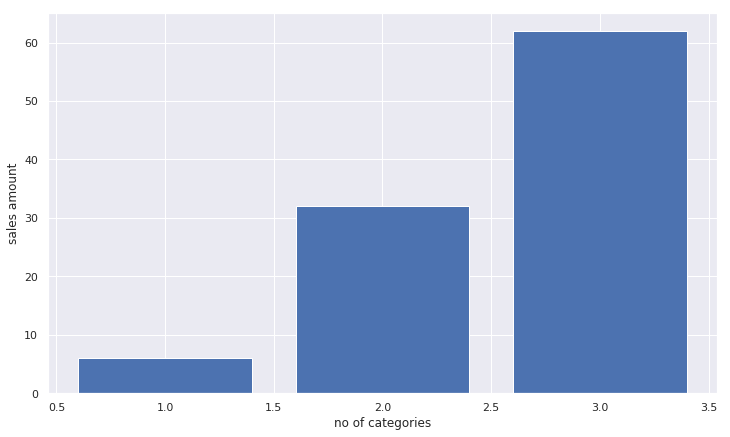

In [121]:
plt.figure(figsize = (12,7))
plt.bar(x = top100_amt.index,height = top100_amt.product_sale_amt)
plt.xlabel('no of categories')
plt.ylabel('sales amount')
plt.show()

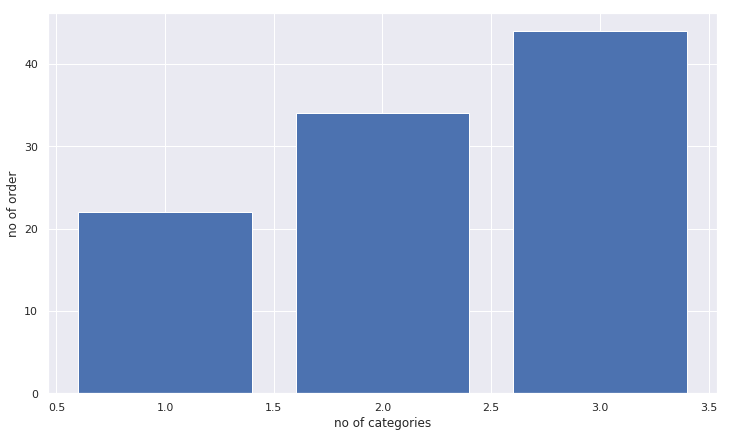

In [122]:
plt.figure(figsize = (12,7))
plt.bar(x = top100_order.index,height = top100_order.no_of_order)
plt.xlabel('no of categories')
plt.ylabel('no of order')
plt.show()

Conclusion:  Product that belongs to mutipule categories tends to be more popular.

### Q3: Find the profile of customers who are interested in the most popular product P00069042

In [9]:
%%sql
select * from facts limit 10

 * postgresql://student@/final_10
10 rows affected.


user_id,product_id,transaction_amt
1000001,P00069042,8370.00
1000001,P00248942,15200.00
1000001,P00087842,1422.00
1000001,P00085442,1057.00
1000002,P00285442,7969.00
1000003,P00193542,15227.00
1000004,P00184942,19215.00
1000004,P00346142,15854.00
1000004,P0097242,15686.00
1000005,P00274942,7871.00


Create a table that only contains customers who purchased P00069042

In [19]:
%%sql
drop table if exists q3;
create table q3 as
select A.user_id,users.gender,users.age,users.occupation,users.city_cat,users.marital from
(select facts.user_id,products.product_id,products.no_of_order,facts.transaction_amt from products 
left join facts
on products.product_id = facts.product_id
where facts.product_id ='P00265242'
order by facts.transaction_amt desc ) as A
left join users
on A.user_id = users.user_id 

 * postgresql://student@/final_10
Done.
1880 rows affected.


[]

In [21]:
q3 = pd.read_sql_table('q3',con=engine)
q3.head()

,user_id,gender,age,occupation,city_cat,marital
0,1000002,M,55+,16,C,0
1,1000705,M,26-35,4,C,1
2,1000760,M,55+,15,A,1
3,1001593,M,26-35,16,C,1
4,1001640,M,36-45,17,C,0


Visualize data for analysis.

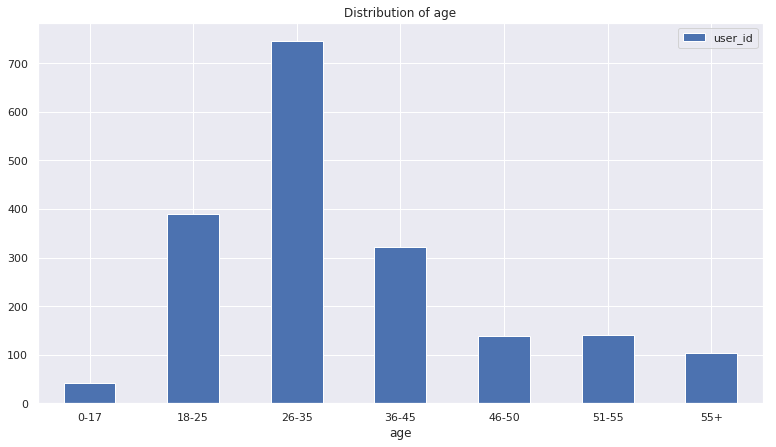

In [32]:
q3.groupby('age').count()[['user_id']].plot(kind = 'bar',rot = 0,figsize = (13,7),title = 'Distribution of age')

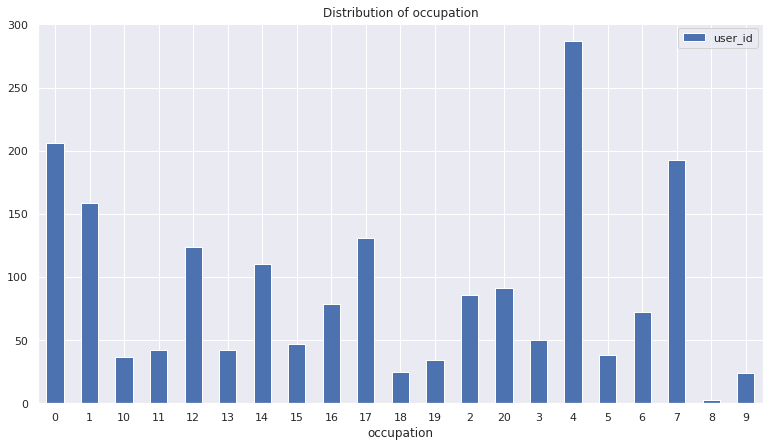

In [34]:
q3.groupby('occupation').count()[['user_id']].plot(kind = 'bar',rot = 0,figsize = (13,7),title = 'Distribution of occupation')

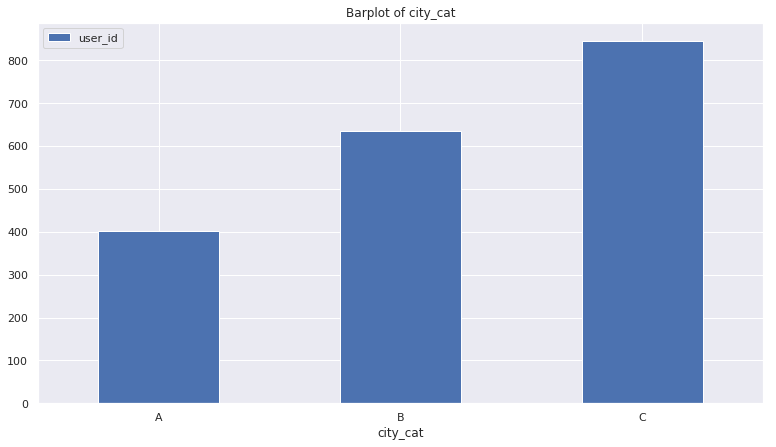

In [35]:
q3.groupby('city_cat').count()[['user_id']].plot(kind = 'bar',rot = 0,figsize = (13,7),title = 'Barplot of city_cat')

In [67]:
not_married = q3[q3.marital == '0'].groupby('gender').count()[['user_id']]
married=q3[q3.marital == '1'].groupby('gender').count()[['user_id']]

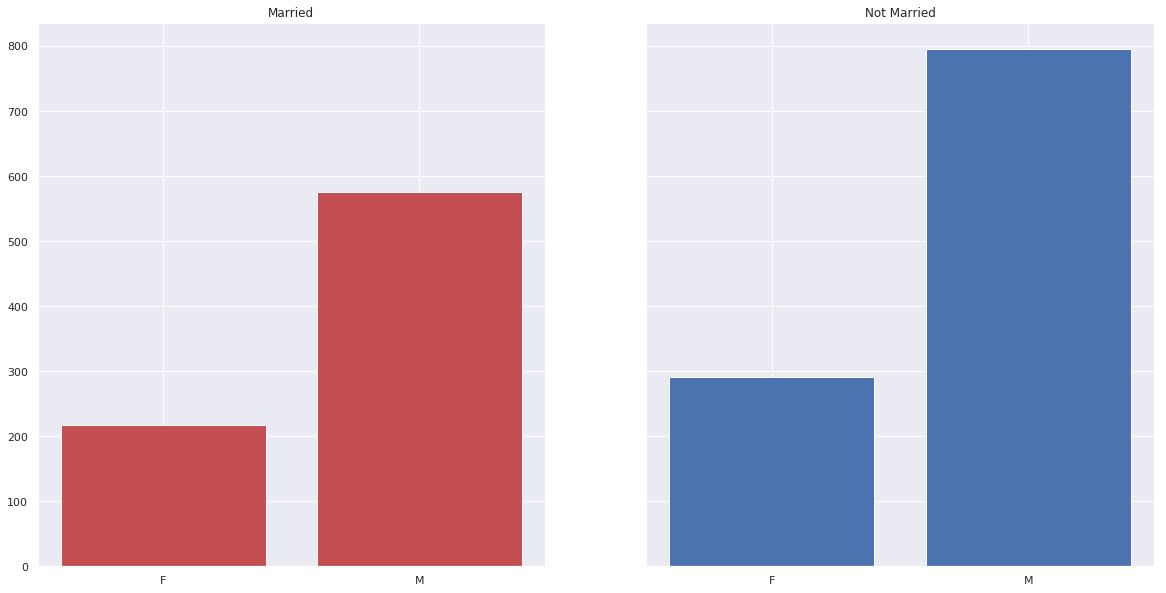

In [66]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,10),sharey=True)
ax1.bar(x = married.index,height = married.user_id,color='r')
ax1.set_title('Married')
ax2.bar(x = not_married.index,height = not_married.user_id,color='b')
ax2.set_title('Not Married')
plt.show()

Conclusion: A single man, who is 26-35 year old, lives in type C or type B city, has an occupation code of 4 is the one who is most interested in product P00069042.